# BigGAN

- BigGAN paper: [Large Scale GAN Training for High Fidelity Natural Image Synthesis](https://arxiv.org/abs/1809.11096))

This network has shown to achieve *state-of-the-art* results, generating high quality images for models trained with very large datasets and many different categories/classes, such as **ImageNet** dataset.

## Importing the libraries

In [ ]:
!git clone https://github.com/huggingface/pytorch-pretrained-BigGAN.git

Cloning into 'pytorch-pretrained-BigGAN'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), 334.64 KiB | 8.81 MiB/s, done.


In [ ]:
%cd pytorch-pretrained-BigGAN/

/content/pytorch-pretrained-BigGAN


In [ ]:
!pip install -r full_requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for libsixel-python: filename=libsixel_python-0.5.0-py3-none-any.whl size=12276 sha256=b32453ce1665f5308731eab48bc17d2305af338262bfa3892fbfee0804f5032c
  Stored in directory: /root/.cache/pip/wheels/97/40/ef/564248af8bb5891d2eb64cd79e4e27cdf6c980702251c71b0f
Successfully built libsixel-python


In [ ]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 103.0 MB/s eta 0:00:00


In [ ]:
#!pip install torch==1.13.1
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample, save_as_images, convert_to_images)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Pretrained model

We will use the model **biggan-deep-256**, which was trained with images from ImageNet (256x256)

The DeepMind's models which we are using are available here:
* https://tfhub.dev/s?publisher=deepmind&q=biggan






* biggan-deep-128: 12-layer, 768-hidden, 12-heads, 110M parameters
* biggan-deep-256: 24-layer, 1024-hidden, 16-heads, 340M parameters
* biggan-deep-512: 12-layer, 768-hidden, 12-heads , 110M parameters

In [ ]:
model = BigGAN.from_pretrained('biggan-deep-256')

100%|██████████| 715/715 [00:00<00:00, 318628.07B/s]


## Network settings

> **Categories**



In [ ]:
!gdown 1cbS0jEZ90mZ2VS4ZDBc9ED8SqiRlqdWy

Downloading...
From: https://drive.google.com/uc?id=1cbS0jEZ90mZ2VS4ZDBc9ED8SqiRlqdWy
To: /content/pytorch-pretrained-BigGAN/biggan_categories.json
100% 29.7k/29.7k [00:00<00:00, 44.3MB/s]


In [ ]:
import json
f = open('/content/pytorch-pretrained-BigGAN/biggan_categories.json')
categories = json.load(f)

In [ ]:
categories_list = {}
for i, category in enumerate(categories):
  categories_list[i] = category

In [ ]:
categories_list

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [ ]:
classes = ['castle', 'mushroom', 'hourglass']

In [ ]:
class_vector = one_hot_from_names(classes, batch_size=3)
class_vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
len(class_vector[0])

1000

In [ ]:
# castle - 1
# mushroom - 2
# hourglass - 3

# One Hot Encoder
# castle -    1 0 0
# mushroom -  0 1 0
# hourglass - 0 0 1

###  Truncation

The smaller the value, the smaller the variety. The higher the value, the greater the variety.

Truncation can be implemented using random noise sample (z) through the function **truncated_noise_sample**(batch_size=1, dim_z=128, truncation=1., seed=None). This function creates a truncated noise vector.

Parameters:
* batch_size: batch size.
* dim_z: dimension of z
* truncation: truncation value
* seed: seed for the random generator

The output will be an array of shape (batch_size, dim_z)

In [ ]:
truncation = 0.5
noise_vector = truncated_noise_sample(truncation = truncation, batch_size = 3)

In [ ]:
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

In [ ]:
type(noise_vector), type(class_vector)

(torch.Tensor, torch.Tensor)

In [ ]:
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

BigGAN(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): Generator(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0-2): 3 x GenBlock(
        (bn_0): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kernel_siz

### Generating the images

Parameters:

* **noise_vector**, or **z**
* **class_vector**
* **truncation**


In [ ]:
def generate_image(noise_vector, class_vector, truncation):
  with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)
  return output

In [ ]:
output = generate_image(noise_vector, class_vector, truncation)

In [ ]:
output.shape

torch.Size([3, 3, 256, 256])

## Showing the results

In [ ]:
output = output.to('cpu')
results = convert_to_images(output)
results

[<PIL.Image.Image image mode=RGB size=256x256 at 0x7F48521D76D0>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x7F48521D7E50>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x7F48521D72B0>]

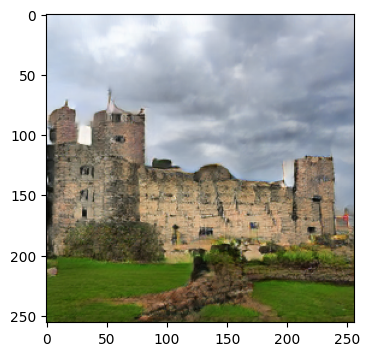

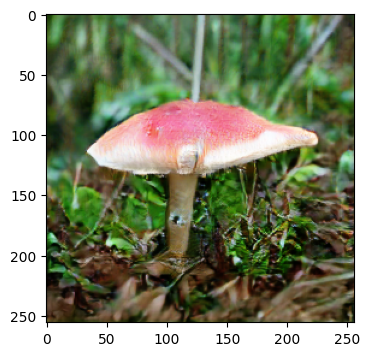

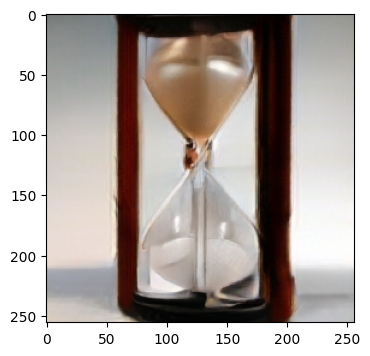

In [ ]:
import matplotlib.pyplot as plt

for image in results:
  plt.figure(figsize = (4,4))
  plt.imshow(image)
  plt.show();

## Saving the results

In [ ]:
import os
os.makedirs('/content/results/', exist_ok = True)
save_as_images(output, '/content/results/result')

## Generating more images

In [ ]:
def generate_image_biggan(category, seed, truncation=0.7, device='gpu'):
  class_vector = one_hot_from_names(category, batch_size=1)
  noise_vector = truncated_noise_sample(truncation = truncation, batch_size = 1, seed = seed)

  noise_vector = torch.from_numpy(noise_vector)
  class_vector = torch.from_numpy(class_vector)

  if device == 'gpu':
    noise_vector = noise_vector.to('cuda')
    class_vector = class_vector.to('cuda')
    model.to('cuda')

  output = generate_image(noise_vector, class_vector, truncation)

  if device == 'gpu':
    output = output.to('cpu')

  result = convert_to_images(output)

  return result

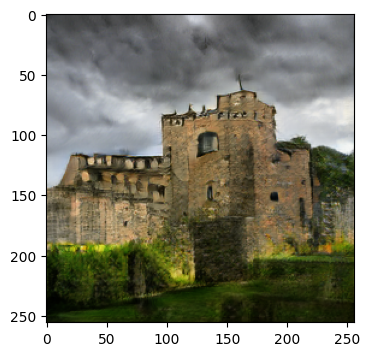

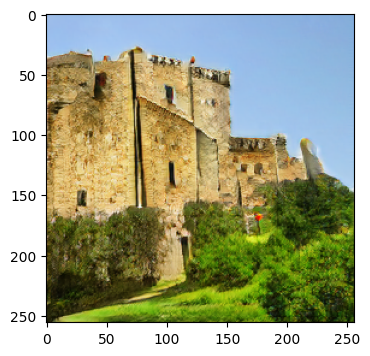

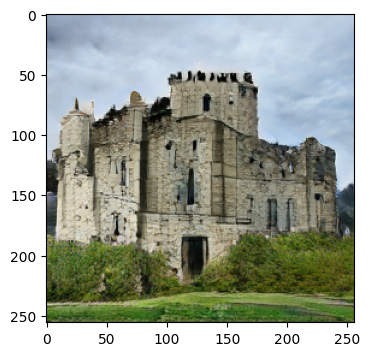

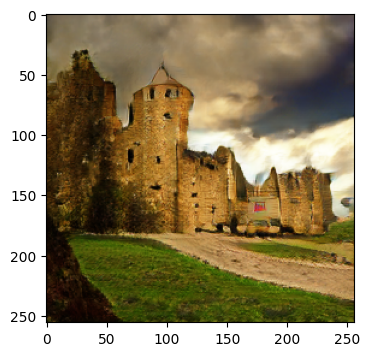

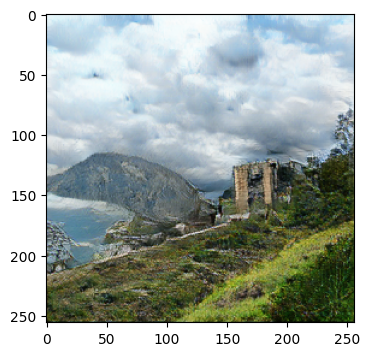

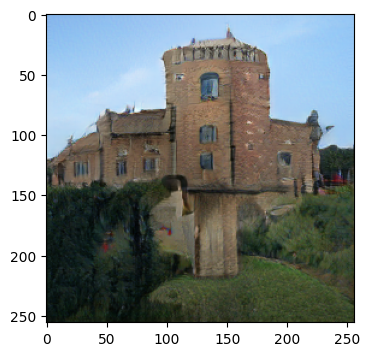

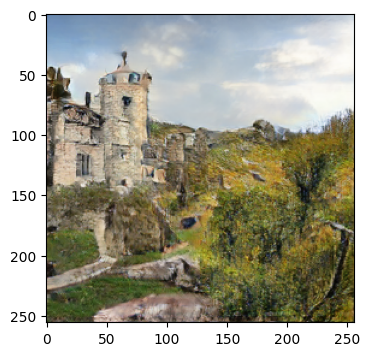

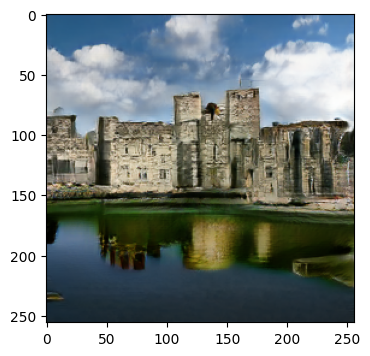

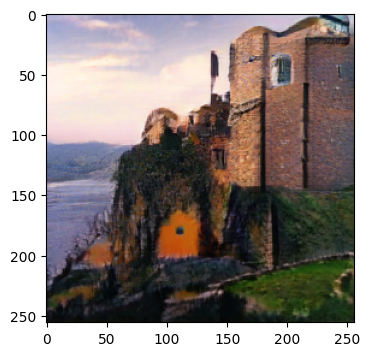

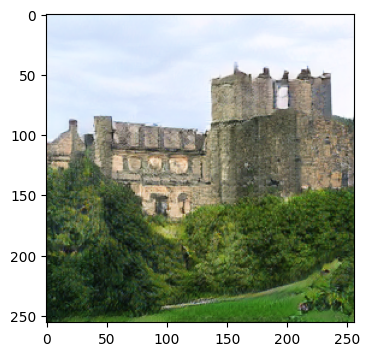

In [ ]:
category = 'castle' #@param {type: "string"}
num_samples = 10 #@param {type: "slider", min:1, max:20, step:1}
truncation = 1 #@param {type: "slider", min:0.02, max:1, step:0.02}
seed = 33873 #@param {type: "slider", min: 0, max: 100000, step: 1}

generated_images = []

for i in range(0, num_samples):
  result = generate_image_biggan(category, seed+i, truncation)
  generated_images.append(result[0])

  plt.figure(figsize=(4,4))
  plt.imshow(result[0])
  plt.show();

In [ ]:
from PIL import Image
import cv2
import numpy as np
from math import ceil
from google.colab.patches import cv2_imshow

def show_images_grid(images, scale=0.25, rows=1):
   w, h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   grid = Image.new('RGBA', (width,height), 'white')
   for i, img in enumerate(images):
     img = img.resize((w,h), Image.ANTIALIAS)
     grid.paste(img, (w*(i % cols), h*(i // cols)))

   grid = np.array(grid)
   return grid

def show_full_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return cv2_imshow(image)

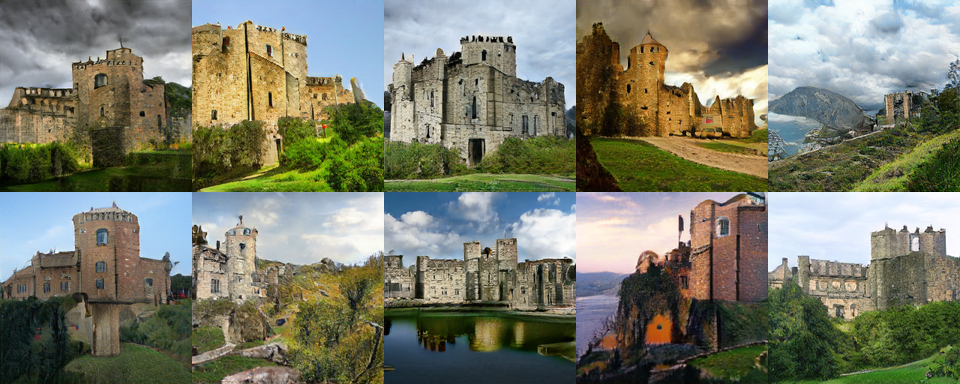

In [ ]:
grid_images = show_images_grid(generated_images, scale=0.75, rows=2)
show_full_image(grid_images)

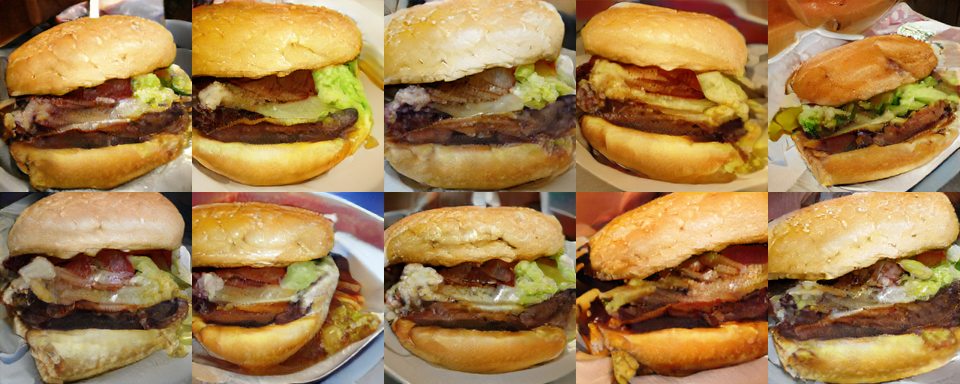

In [ ]:
category = 'cheeseburger'   #@param {type:"string"}
num_samples = 10   #@param {type:"slider", min:1, max:20, step:1}
truncation = 0.7    #@param {type:"slider", min:0.02, max:1, step:0.02}
seed = 33873  #@param {type:"slider", min:0, max:100000, step:1}

generated_images = []

for i in range(0, num_samples):

  result = generate_image_biggan(category, seed+i, truncation)
  generated_images.append(result[0])

grid_images = show_images_grid(generated_images, scale=0.75, rows=2)
show_full_image(grid_images)

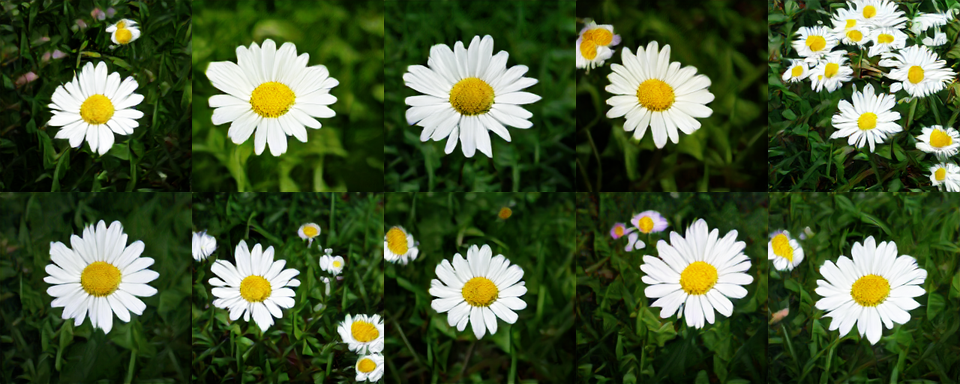

In [ ]:
category = 'daisy'   #@param {type:"string"}
num_samples = 10   #@param {type:"slider", min:1, max:20, step:1}
truncation = 0.62    #@param {type:"slider", min:0.02, max:1, step:0.02}
seed = 33873  #@param {type:"slider", min:0, max:100000, step:1}

generated_images = []

for i in range(0, num_samples):

  result = generate_image_biggan(category, seed+i, truncation)
  generated_images.append(result[0])

grid_images = show_images_grid(generated_images, scale=0.75, rows=2)
show_full_image(grid_images)